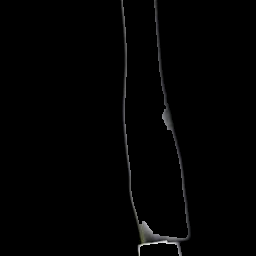

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


# Load the image
image = cv2.imread('/content/drive/MyDrive/biomed/firstRun/train/images/002.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply a Gaussian blur to the grayscale image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Perform edge detection
edges = cv2.Canny(blurred, 30, 150)

# Perform a dilation and erosion to close gaps in between object edges
dilated = cv2.dilate(edges, None, iterations=2)
eroded = cv2.erode(dilated, None, iterations=1)

# Find contours in the eroded image
contours, hierarchy = cv2.findContours(eroded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on area
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 500]

# Create an empty mask to store the segmented arm
mask = np.zeros_like(gray)

# Draw the filtered contours on the mask
cv2.drawContours(mask, filtered_contours, -1, (255), thickness=cv2.FILLED)

# Bitwise-and for the final segmented image
segmented_image = cv2.bitwise_and(image, image, mask=mask)

# Display the image
cv2_imshow(segmented_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

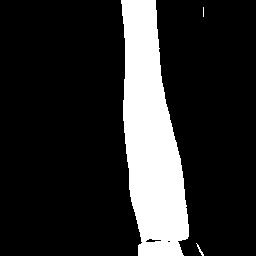

True

In [ ]:
import cv2

# Load the image
image = cv2.imread('/content/drive/MyDrive/biomed/firstRun/train/images/002.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold the image to create a binary mask where white pixels are set to 255 and black pixels are set to 0
ret, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

# Show the binary mask
cv2_imshow(thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('/content/drive/MyDrive/biomed/firstRun/armoutlines/002_mask.jpg', thresh)


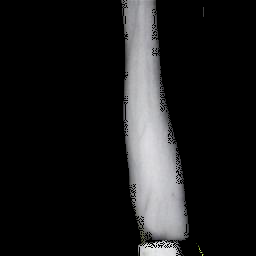

In [ ]:
import cv2
import numpy as np

# Load the original image and the mask image
img = cv2.imread('/content/drive/MyDrive/biomed/firstRun/train/images/002.jpg')
mask = cv2.imread('/content/drive/MyDrive/biomed/firstRun/armoutlines/002_mask.jpg', cv2.IMREAD_GRAYSCALE)

# Create a new black image
new_img = np.zeros_like(img)

# Copy the pixels from the original image that correspond to the white pixels in the mask image
new_img[mask == 255] = img[mask == 255]

# Show the new image
cv2_imshow(new_img)



In [ ]:
import cv2
import numpy as np
import os

# Set the path to the folder containing the original images
path = '/content/drive/MyDrive/biomed/firstRun/train/images/'

# Set the path to the folder where the new images will be saved
new_path = '/content/drive/MyDrive/biomed/processed_images'

# Iterate through all images in the folder
for filename in os.listdir(path):
    # Load the original image
    img = cv2.imread(os.path.join(path, filename))

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold the image to create a binary mask where white pixels are set to 255 and black pixels are set to 0
    ret, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

    # Save the binary mask
    cv2.imwrite(os.path.join('/content/drive/MyDrive/biomed/firstRun/armoutlines', filename), thresh)

    # Create a new black image
    new_img = np.zeros_like(img)

    # Copy the pixels from the original image that correspond to the white pixels in the mask image
    new_img[thresh == 255] = img[thresh == 255]

    # Save the new image
    cv2.imwrite(os.path.join(new_path, filename), new_img)

In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import glob
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.applications.resnet50 import preprocess_input

class DataLoader(Sequence):
    def __init__(self, image_folder, mask_folder, batch_size):
        self.image_paths = sorted(glob.glob(os.path.join(image_folder, '*.jpg')))
        self.mask_paths = sorted(glob.glob(os.path.join(mask_folder, '*.png')))
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_x_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_paths = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x = np.zeros((self.batch_size, 256, 256, 3), dtype='float32')
        batch_y = np.zeros((self.batch_size, 256, 256, 1), dtype='float32')

        for i, (x_path, y_path) in enumerate(zip(batch_x_paths, batch_y_paths)):
            # Load and preprocess the image
            x = load_img(x_path, target_size=(256, 256))
            x = img_to_array(x)
            x = preprocess_input(x)

            # Load and preprocess the mask
            y = load_img(y_path, color_mode='grayscale', target_size=(256, 256))
            y = img_to_array(y)
            y /= 255.

            batch_x[i] = x
            batch_y[i] = y

        return batch_x, batch_y

In [ ]:
num_classes = 1
input_shape = (256, 256, 3)
batch_size = 2
epochs = 100
learning_rate = .00010
train_image_folder = '/content/drive/MyDrive/biomed/processed_images'
train_mask_folder = '/content/drive/MyDrive/biomed/firstRun/train/masks'
val_image_folder = '/content/drive/MyDrive/biomed/firstRun/validation/images'
val_mask_folder = '/content/drive/MyDrive/biomed/firstRun/validation/masks'



train_loader = DataLoader(train_image_folder, train_mask_folder, batch_size)
val_loader = DataLoader(val_image_folder, val_mask_folder, batch_size)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.models import Model

def yolo_v8(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    # YOLOv8 backbone
    x = Conv2D(32, (3, 3), strides=1, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)

    # YOLOv8 head
    x = Conv2D(1024, (3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(512, (1, 1), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(256, (1, 1), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_classes, (1, 1), strides=1, padding="same")(x)
    x = Activation("sigmoid")(x)

    # Upsample to the original input size
    output_tensor = UpSampling2D(size=(32, 32))(x)

    model = Model(input_tensor, output_tensor)
    return model

model = yolo_v8(input_shape, num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

model.fit(train_loader, epochs=epochs, validation_data=val_loader)

model.save('/content/drive/MyDrive/biomed/firstRun/Models/model428.h5')

Epoch 1/100
27/27 [==============================] - 6s 19ms/step - loss: 0.6925 - val_loss: 0.6918
Epoch 2/100
27/27 [==============================] - 0s 11ms/step - loss: 0.6911 - val_loss: 0.6905
Epoch 3/100
27/27 [==============================] - 0s 10ms/step - loss: 0.6898 - val_loss: 0.6891
Epoch 4/100
27/27 [==============================] - 0s 10ms/step - loss: 0.6885 - val_loss: 0.6878
Epoch 5/100
27/27 [==============================] - 0s 10ms/step - loss: 0.6871 - val_loss: 0.6864
Epoch 6/100
27/27 [==============================] - 0s 10ms/step - loss: 0.6858 - val_loss: 0.6851
Epoch 7/100
27/27 [==============================] - 0s 10ms/step - loss: 0.6845 - val_loss: 0.6838
Epoch 8/100
27/27 [==============================] - 0s 10ms/step - loss: 0.6831 - val_loss: 0.6824
Epoch 9/100
27/27 [==============================] - 0s 11ms/step - loss: 0.6818 - val_loss: 0.6811
Epoch 10/100
27/27 [==============================] - 0s 10ms/step - loss: 0.6805 - val_loss: 0.6798

1/1 [==============================] - 0s 176ms/step


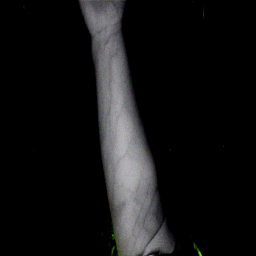

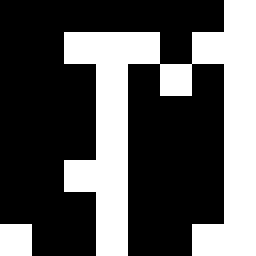

1/1 [==============================] - 0s 24ms/step


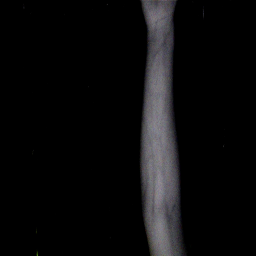

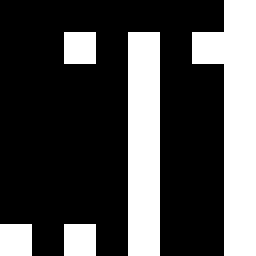

1/1 [==============================] - 0s 22ms/step


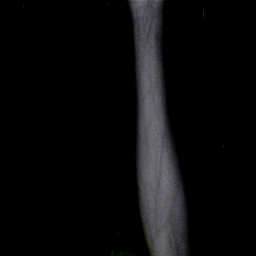

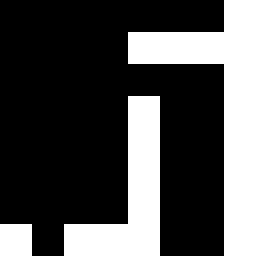

1/1 [==============================] - 0s 22ms/step


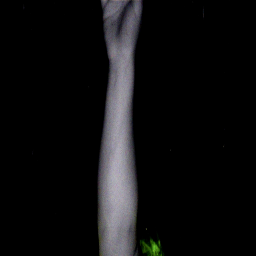

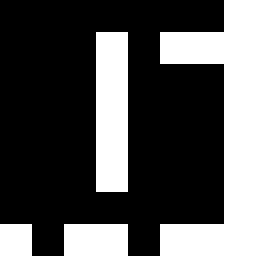

1/1 [==============================] - 0s 21ms/step


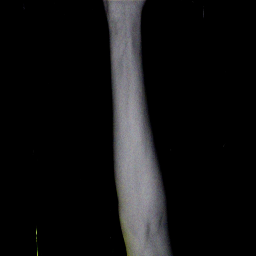

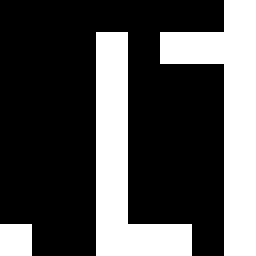

1/1 [==============================] - 0s 21ms/step


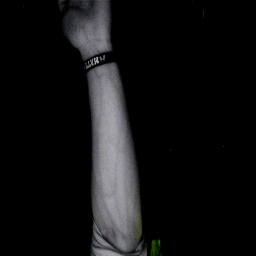

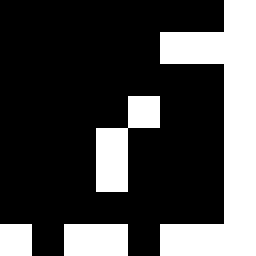

1/1 [==============================] - 0s 21ms/step


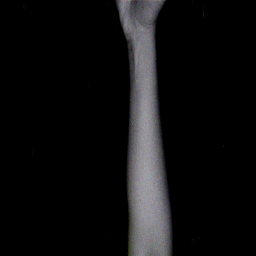

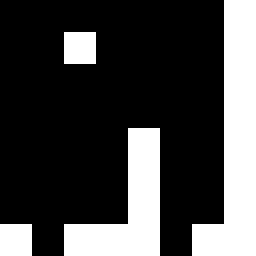

1/1 [==============================] - 0s 21ms/step


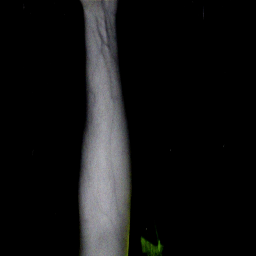

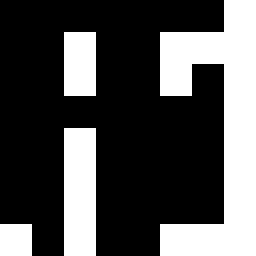

1/1 [==============================] - 0s 22ms/step


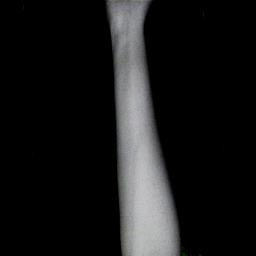

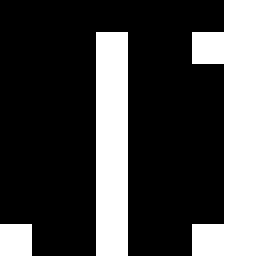

1/1 [==============================] - 0s 22ms/step


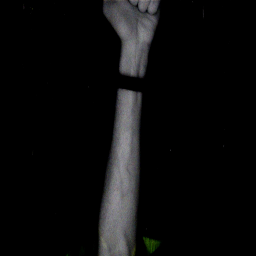

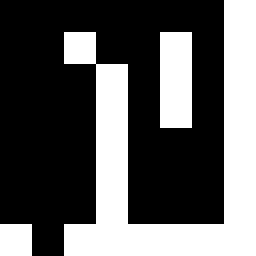

1/1 [==============================] - 0s 22ms/step


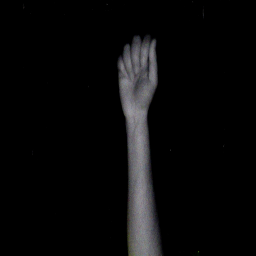

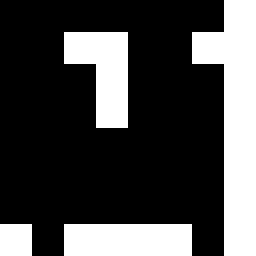

1/1 [==============================] - 0s 21ms/step


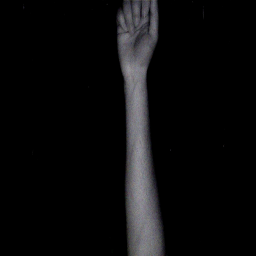

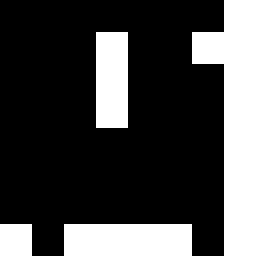

1/1 [==============================] - 0s 22ms/step


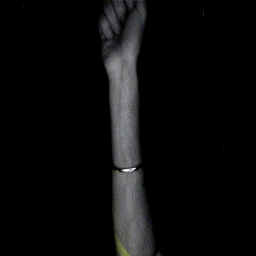

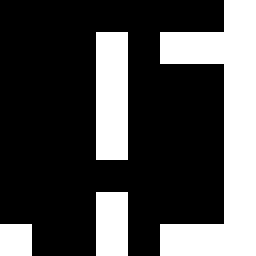

1/1 [==============================] - 0s 21ms/step


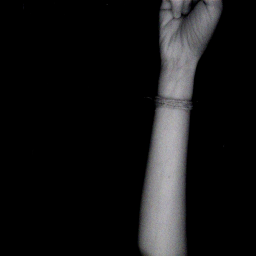

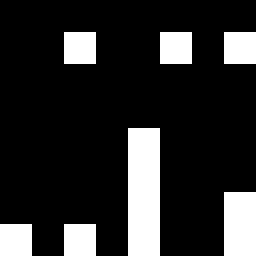

1/1 [==============================] - 0s 21ms/step


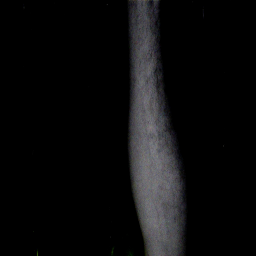

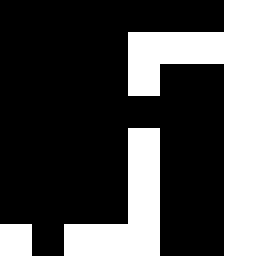

1/1 [==============================] - 0s 22ms/step


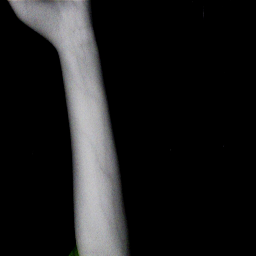

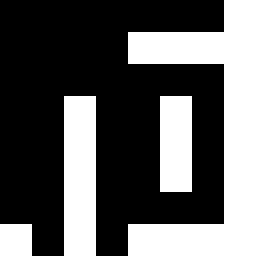

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/biomed/firstRun/Models/model428.h5'
image_folder = '/content/drive/MyDrive/biomed/firstRun/test'

# Load the model
model = load_model(model_path)

# Loop through all images in the folder
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg'):
        # Load and preprocess the image
        image_path = os.path.join(image_folder, filename)
        image = load_img(image_path, target_size=(256, 256))
        x = img_to_array(image)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Predict the segmentation mask
        y_pred = model.predict(x)[0]
        y_pred = np.round(y_pred)

        # Convert the mask to an image
        mask = array_to_img(y_pred)

        # Show the original image and predicted mask side by side
        image.show()
        mask.show()

In [ ]:
import os
import glob
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.applications.resnet50 import preprocess_input

class DataLoader(Sequence):
    def __init__(self, image_folder, mask_folder, batch_size):
        self.image_paths = sorted(glob.glob(os.path.join(image_folder, '*.jpg')))
        self.mask_paths = sorted(glob.glob(os.path.join(mask_folder, '*.png')))
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_x_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_paths = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x = np.zeros((self.batch_size, 256, 256, 3), dtype='float32')
        batch_y = np.zeros((self.batch_size, 256, 256, 1), dtype='float32')

        for i, (x_path, y_path) in enumerate(zip(batch_x_paths, batch_y_paths)):
            # Load and preprocess the image
            x = load_img(x_path, target_size=(256, 256))
            x = img_to_array(x)
            x = preprocess_input(x)

            # Load and preprocess the mask
            y = load_img(y_path, color_mode='grayscale', target_size=(256, 256))
            y = img_to_array(y)
            y /= 255.

            batch_x[i] = x
            batch_y[i] = y

        return batch_x, batch_y

In [ ]:
num_classes = 1
input_shape = (256, 256, 3)
batch_size = 2
epochs = 100
learning_rate = 1e-3

image_folder = '/content/drive/MyDrive/biomed/processed_images'
mask_folder = '/content/drive/MyDrive/biomed/firstRun/train/masks'

data_loader = DataLoader(image_folder, mask_folder, batch_size)

In [ ]:
def yolo_v8(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    # YOLOv8 backbone
    x = Conv2D(32, (3, 3), strides=1, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)

    # YOLOv8 head
    x = Conv2D(1024, (3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(512, (1, 1), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(256, (1, 1), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_classes, (1, 1), strides=1, padding="same")(x)
    x = Activation("sigmoid")(x)

    # Upsample to the original input size
    output_tensor = UpSampling2D(size=(32, 32))(x)

    model = Model(input_tensor, output_tensor)
    return model

In [ ]:
model = yolo_v8(input_shape, num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy')
model.fit(data_loader, epochs=epochs)
model.save('/content/drive/MyDrive/biomed/firstRun/Models/model42999.h5')

Epoch 1/100
27/27 [==============================] - 6s 10ms/step - loss: 0.6867
Epoch 2/100
27/27 [==============================] - 0s 9ms/step - loss: 0.6734
Epoch 3/100
27/27 [==============================] - 0s 10ms/step - loss: 0.6604
Epoch 4/100
27/27 [==============================] - 0s 9ms/step - loss: 0.6476
Epoch 5/100
27/27 [==============================] - 0s 9ms/step - loss: 0.6351
Epoch 6/100
27/27 [==============================] - 0s 9ms/step - loss: 0.6229
Epoch 7/100
27/27 [==============================] - 0s 9ms/step - loss: 0.6109
Epoch 8/100
27/27 [==============================] - 0s 9ms/step - loss: 0.5991
Epoch 9/100
27/27 [==============================] - 0s 9ms/step - loss: 0.5877
Epoch 10/100
27/27 [==============================] - 0s 9ms/step - loss: 0.5764
Epoch 11/100
27/27 [==============================] - 0s 9ms/step - loss: 0.5654
Epoch 12/100
27/27 [==============================] - 0s 9ms/step - loss: 0.5546
Epoch 13/100
27/27 [===============

1/1 [==============================] - 0s 186ms/step


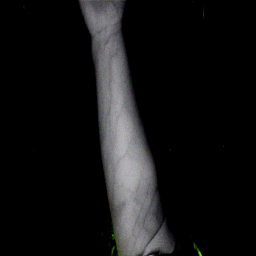

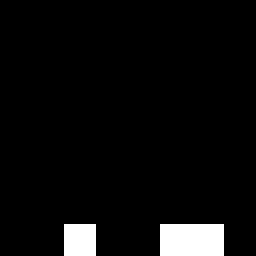

1/1 [==============================] - 0s 23ms/step


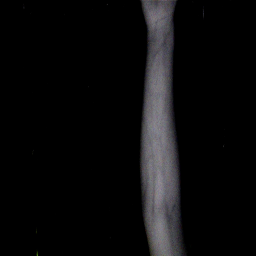

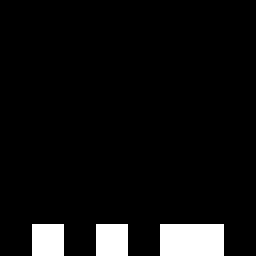

1/1 [==============================] - 0s 22ms/step


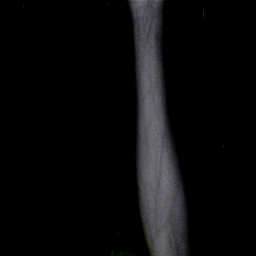

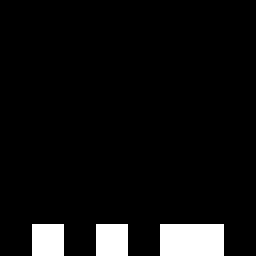

1/1 [==============================] - 0s 23ms/step


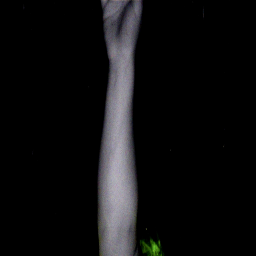

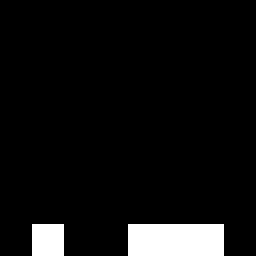

1/1 [==============================] - 0s 22ms/step


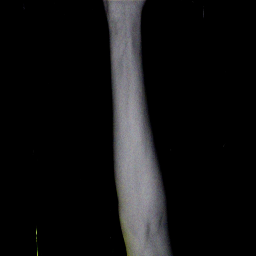

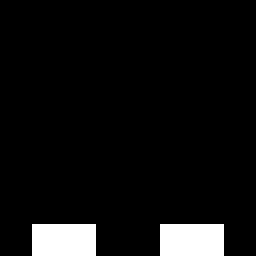

1/1 [==============================] - 0s 22ms/step


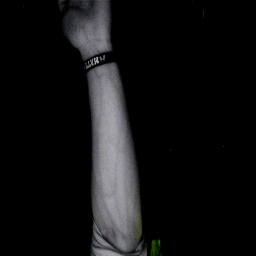

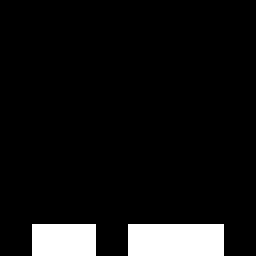

1/1 [==============================] - 0s 22ms/step


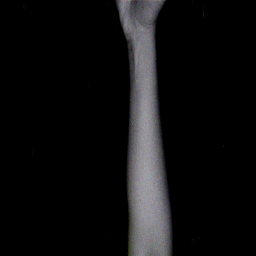

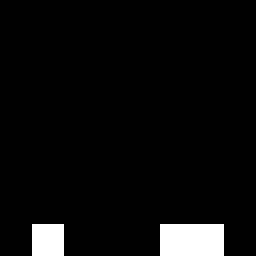

1/1 [==============================] - 0s 22ms/step


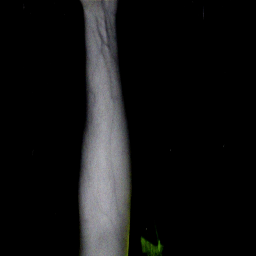

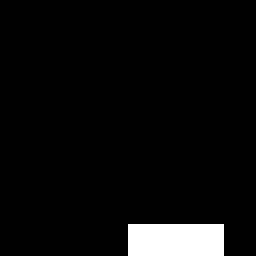

1/1 [==============================] - 0s 21ms/step


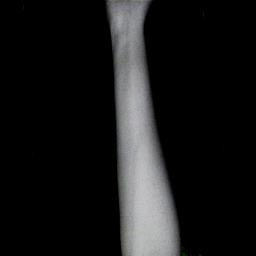

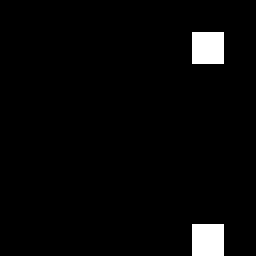

1/1 [==============================] - 0s 21ms/step


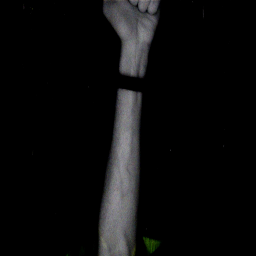

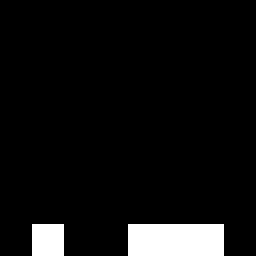

1/1 [==============================] - 0s 22ms/step


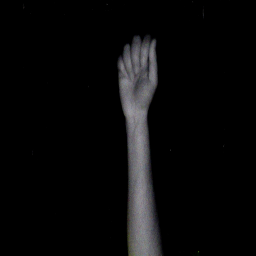

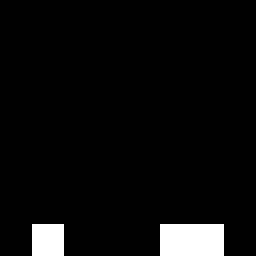

1/1 [==============================] - 0s 22ms/step


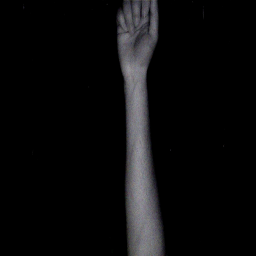

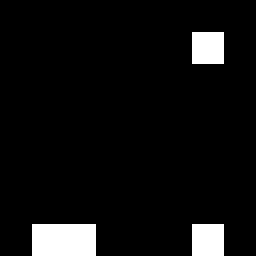

1/1 [==============================] - 0s 22ms/step


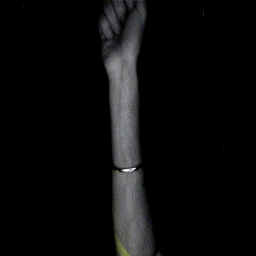

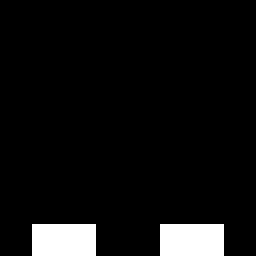

1/1 [==============================] - 0s 23ms/step


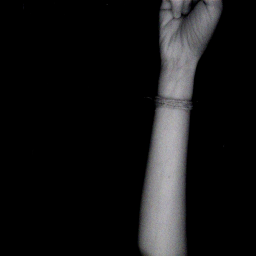

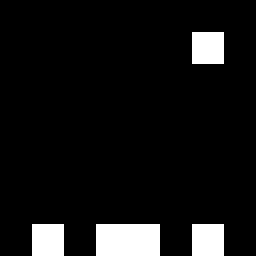

1/1 [==============================] - 0s 22ms/step


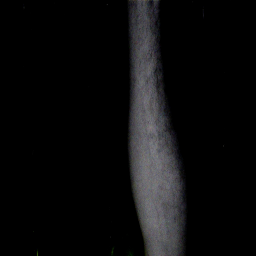

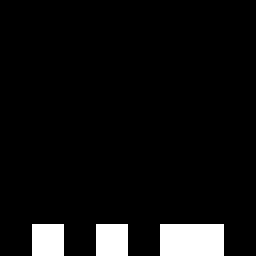

1/1 [==============================] - 0s 21ms/step


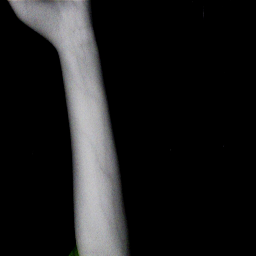

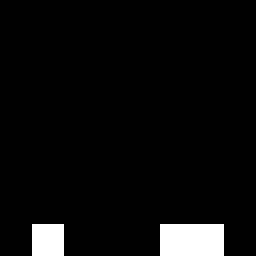

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/biomed/firstRun/Models/model42999.h5'
image_folder = '/content/drive/MyDrive/biomed/firstRun/test'

# Load the model
model = load_model(model_path)

# Loop through all images in the folder
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg'):
        # Load and preprocess the image
        image_path = os.path.join(image_folder, filename)
        image = load_img(image_path, target_size=(256, 256))
        x = img_to_array(image)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Predict the segmentation mask
        y_pred = model.predict(x)[0]
        y_pred = np.round(y_pred)

        # Convert the mask to an image
        mask = array_to_img(y_pred)

        # Show the original image and predicted mask side by side
        image.show()
        mask.show()